# **LAB 2 - Pruning, Quantization and Huffman Coding**

**Connecting to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ECE 591/Lab 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECE 591/Lab 2


**Importing Libraries**

In [2]:
from vgg16 import VGG16_half
from train_util import train, finetune_after_prune, test
from quantize import *
from huffman_coding import huffman_coding, _huffman_coding_per_layer
from pruned_layers import *
from summary import summary
import torch
import numpy as np
from prune import prune
import time
import matplotlib.pyplot as plt
import psutil

In [3]:
# Define device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Full-Precision Model Training**

In [4]:
# Create the VGG-16_half model
net = VGG16_half()
net = net.to(device)

# Hyperparameter tuning
epochs = 60  # You can increase this number as needed
batch_size = 64 # Experiment with batch sizes
lr = 0.01  # Initial learning rate
reg = 0.001  # Regularization strength

# Uncomment to load pretrained weights
#net.load_state_dict(torch.load("net_before_pruning.pt"))

# Tune the hyperparameters and train
#train(net, epochs=epochs, batch_size=batch_size, lr=lr, reg=reg)
#train(net, epochs=10, batch_size=128, lr=0.0001, reg=0.01)

In [5]:
# Load the best weight parameters
net.load_state_dict(torch.load("net_before_pruning.pt"))
# Test the model
test(net)

Files already downloaded and verified
Test Loss=0.2894, Test accuracy=0.9156


In [6]:
print("-----Summary before pruning-----")
summary(net)
print("-------------------------------")

-----Summary before pruning-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		864			0.000000
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		9216			0.000000
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		18432			0.000000
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		36864			0.000000
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		73728			0.000000
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		147456			0.000000
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		147456			0.000000
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		294912			0.000000
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		589824			0.000000
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		589824			0.000000
29		Batch

In [7]:
model_size_bytes = sum(p.numel() * p.element_size() for p in net.parameters())

# Convert to megabytes (MB)
model_size_MB = model_size_bytes / (1024 * 1024)

print(f"Size of the model's weights: {model_size_MB:.2f} MB")

Size of the model's weights: 14.56 MB


## **Pruning and Fine-Tuning with Pruned Connections**

**Pruning**

In [ ]:
# Test accuracy before fine-tuning
prune(net, method='std', q=60.6987, s=0.75)
test(net)

Files already downloaded and verified
Test Loss=0.7853, Test accuracy=0.7623


In [ ]:
print("-----Summary After pruning (Before Fine-tuning)-----")
summary(net)
print("-------------------------------")

-----Summary After pruning (Before Fine-tuning)-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		340			0.606481
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		3622			0.606988
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		7244			0.606988
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		14488			0.606988
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		28976			0.606988
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		57952			0.606988
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		57952			0.606988
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		115904			0.606988
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		231809			0.606986
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		231809			0

**Relationship between Sparsity and Accuracy Drop with respect to Sensitivity**
Assignment 2 - PART D

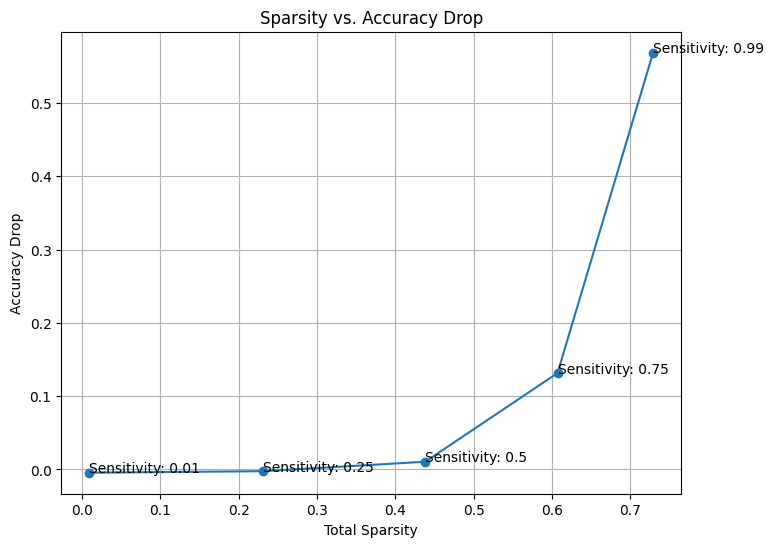

In [ ]:
Sensitivity = [0.01, 0.25, 0.5, 0.75, 0.99]
Test_Accuracy = [0.9156, 0.9135, 0.9006, 0.7796, 0.3426]
Total_Sparsity = [ 0.009386, 0.231119, 0.438113, 0.606987, 0.728948]

# Calculate accuracy drop from the highest accuracy
Original_Accuracy = 0.9111
Accuracy_Drop = [Original_Accuracy - acc for acc in Test_Accuracy]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(Total_Sparsity, Accuracy_Drop, marker='o', linestyle='-')
plt.title('Sparsity vs. Accuracy Drop')
plt.xlabel('Total Sparsity')
plt.ylabel('Accuracy Drop')
plt.grid(True)

# Annotate points with their corresponding sensitivity values
for i, txt in enumerate(Sensitivity):
    plt.annotate(f'Sensitivity: {Sensitivity[i]}', (Total_Sparsity[i], Accuracy_Drop[i]))

plt.show()

After experiment chosen the method of Standard Deviation with Sensitivity = 0.75

**Fine-Tuning**

In [14]:
# Uncomment to load pretrained weights
#net.load_state_dict(torch.load("net_after_pruning.pt"))

# Comment if you have loaded pretrained weights
#finetune_after_prune(net, epochs=30, batch_size=128, lr=0.01, reg=0.0001)

In [8]:
# Load the best weight paramters
net.load_state_dict(torch.load("net_after_pruning.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3291, Test accuracy=0.9009


In [9]:
print("-----Summary After pruning-----")
summary(net)
print("-------------------------------")

-----Summary After pruning-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		230			0.733796
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		2528			0.725694
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		6588			0.642578
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		14418			0.608887
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		28970			0.607069
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		58029			0.606466
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		56832			0.614583
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		110993			0.623640
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		220116			0.626811
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		210881			0.642468
29		BatchNorm

## **Quantization**

In [10]:
# Measure memory consumption before the operation
start_memory = psutil.virtual_memory().used / (1024 ** 3)  # in GB

start_time = time.time()

centers = quantize_whole_model(net, bits=4)   # K-means Clustering + Quantization
np.save("codebook_vgg16.npy", centers)    # Save the cluster centers to a numpy file

end_time = time.time()

# Measure memory consumption after the operation
end_memory = psutil.virtual_memory().used / (1024 ** 3)  # in GB

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")

memory_used = end_memory - start_memory
print(f"Memory used during the operation: {memory_used:.2f} GB")

Complete 1 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 2 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 3 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 4 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 5 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 6 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 7 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 8 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 9 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 10 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 11 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 12 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 13 layers quantization for PrunedConv...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 14 layers quantization for PruneLinear...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 15 layers quantization for PruneLinear...
Complete 16 layers quantization for PruneLinear...
Elapsed time: 78.335603 seconds
Memory used during the operation: -0.08 GB


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
net.load_state_dict(torch.load("net_after_quantization.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3420, Test accuracy=0.8962


In [12]:
print("-----Summary After Quantization-----")
summary(net)
print("-------------------------------")

-----Summary After Quantization-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		864			0.000000
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		9216			0.000000
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		18432			0.000000
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		36864			0.000000
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		73728			0.000000
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		147456			0.000000
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		147456			0.000000
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		294912			0.000000
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		589824			0.000000
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		589824			0.000000
29		B

## **Huffman Coding**

In [13]:
frequency_map, encoding_map = huffman_coding(net, centers)
np.save("huffman_encoding", encoding_map)
np.save("huffman_freq", frequency_map)

Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 1.9271 bits
Complete 1 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 1.9354 bits
Complete 2 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.2368 bits
Complete 3 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.3995 bits
Complete 4 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.3946 bits
Complete 5 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.3890 bits
Complete 6 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Ave

In [14]:
import numpy as np

# Load the Huffman encoding and frequency maps
encoding_data = np.load("huffman_encoding.npy", allow_pickle=True)
frequency_data = np.load("huffman_freq.npy", allow_pickle=True)

# Access the arrays
encoding_map = encoding_data[()]
frequency_map = frequency_data[()]


In [15]:
import numpy as np

# Load the saved Huffman frequency and encoding data
freq_map = np.load("huffman_freq.npy", allow_pickle=True)
encodings_map = np.load("huffman_encoding.npy", allow_pickle=True)

# Iterate through the loaded data
for layer_ind, (freq, encodings) in enumerate(zip(freq_map, encodings_map)):
    print(f"Layer {layer_ind + 1}:")
    for key, value in freq.items():
        print(f"Frequency: {key} - {value}")

    for key, value in encodings.items():
        print(f"Encoding: {key} - {value}")



Layer 1:
Frequency: 6.7520887e-09 - 634
Frequency: 0.19361992 - 14
Frequency: -0.46716404 - 3
Frequency: 0.23157607 - 12
Frequency: 0.10653642 - 46
Frequency: 0.15035912 - 18
Frequency: -0.3061535 - 5
Frequency: -0.10213756 - 38
Frequency: -0.21670783 - 14
Frequency: -0.16538705 - 21
Frequency: -0.13557835 - 31
Frequency: 0.4275065 - 5
Frequency: 0.2694088 - 7
Frequency: -0.37376916 - 3
Frequency: -0.262556 - 7
Frequency: 0.340559 - 6
Encoding: 0.10653642 - 000
Encoding: -0.3061535 - 001000
Encoding: 0.4275065 - 001001
Encoding: -0.37376916 - 0010100
Encoding: -0.46716404 - 0010101
Encoding: 0.340559 - 001011
Encoding: 0.23157607 - 00110
Encoding: -0.21670783 - 00111
Encoding: -0.262556 - 010000
Encoding: 0.2694088 - 010001
Encoding: 0.19361992 - 01001
Encoding: -0.13557835 - 0101
Encoding: -0.10213756 - 0110
Encoding: 0.15035912 - 01110
Encoding: -0.16538705 - 01111
Encoding: 6.7520887e-09 - 1
Layer 2:
Frequency: 9.5926225e-08 - 6688
Frequency: 0.10517792 - 100
Frequency: 0.14000821 -

In [16]:
# Initialize variables to store the total weighted storage and total parameters
total_weighted_storage = 0.0
total_parameters = 0

# Iterate through layers in your network
for i, (frequencies, encodings) in enumerate(zip(frequency_map, encoding_map), start=1):
    layer_name = str(i)  # You may use the layer index as the name

    # Calculate the weighted sum for the current layer
    weighted_storage_for_layer = sum(frequencies[key] * len(encodings[key]) for key in encodings)

    # Add the weighted storage to the total
    total_weighted_storage += weighted_storage_for_layer

    # Add the total parameters for the current layer to the overall total
    total_parameters += sum(frequencies.values())

# Calculate the weighted average storage for the entire network
weighted_average = total_weighted_storage / total_parameters

print("Weighted Average Storage: %.2f" %weighted_average)


Weighted Average Storage: 2.17


In [17]:
def calculate_encoded_weights_size(encoding_map, frequency_map):
    total_bits = 0

    # Step 1: Calculate the bit lengths for each weight using the encoding map
    for i in range(len(frequency_map)):
        weight = list(frequency_map[i].keys())[0]
        huffman_code = encoding_map[i]
        bits_required = len(huffman_code) * list(frequency_map[i].values())[0]  # Multiply by frequency for repeated values
        total_bits += bits_required

    # Step 2: Calculate the size of encoded weights in bytes (divide by 8)
    encoded_weights_size_bytes = total_bits // 8

    return encoded_weights_size_bytes

# Example usage:
encoded_weights_size_bytes = calculate_encoded_weights_size(encodings_map, freq_map)
print("Size of Encoded Weights: {} bytes".format(encoded_weights_size_bytes))

Size of Encoded Weights: 4706828 bytes
